[View in Colaboratory](https://colab.research.google.com/github/ajoshiusc/deepReg/blob/master/deep_rigid_usc.ipynb)

------------------------------
Loading and preprocessing train data...
------------------------------
Creating and compiling model...
Fitting Model
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 8s 19ms/step - loss: 102.3613 - mean_squared_error: 102.3613 - val_loss: 81.9868 - val_mean_squared_error: 81.9868
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 65.1272 - mean_squared_error: 65.1272 - val_loss: 59.7503 - val_mean_squared_error: 59.7503
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 43.9674 - mean_squared_error: 43.9674 - val_loss: 59.7712 - val_mean_squared_error: 59.7712
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 28.3346 - mean_squared_error: 28.3346 - val_loss: 42.3593 - val_mean_squared_error: 42.3593
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 21.7539 - mean_squared_error: 21.7539 - val_loss: 43.8995 - val_me

409/409 [==============================] - 7s 16ms/step - loss: 39.1994 - mean_squared_error: 39.1994 - val_loss: 39.6100 - val_mean_squared_error: 39.6100
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 24.0135 - mean_squared_error: 24.0135 - val_loss: 32.9875 - val_mean_squared_error: 32.9875
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 16.5942 - mean_squared_error: 16.5942 - val_loss: 37.9980 - val_mean_squared_error: 37.9980
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 11.5257 - mean_squared_error: 11.5257 - val_loss: 36.9954 - val_mean_squared_error: 36.9954
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 9.4178 - mean_squared_error: 9.4178 - val_loss: 33.1887 - val_mean_squared_error: 33.1887
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 36.7060 - mean_squared_error: 36.7060 - val_loss: 55.1298 - va

409/409 [==============================] - 7s 16ms/step - loss: 27.1918 - mean_squared_error: 27.1918 - val_loss: 42.2165 - val_mean_squared_error: 42.2165
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 22.0735 - mean_squared_error: 22.0735 - val_loss: 44.2360 - val_mean_squared_error: 44.2360
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 15.9334 - mean_squared_error: 15.9334 - val_loss: 44.8431 - val_mean_squared_error: 44.8431
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 13.2898 - mean_squared_error: 13.2898 - val_loss: 38.6544 - val_mean_squared_error: 38.6544
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 82.4112 - mean_squared_error: 82.4112 - val_loss: 92.9729 - val_mean_squared_error: 92.9729
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 63.5481 - mean_squared_error: 63.5481 - val_loss: 56.3151 - 

409/409 [==============================] - 7s 16ms/step - loss: 39.5246 - mean_squared_error: 39.5246 - val_loss: 58.9982 - val_mean_squared_error: 58.9982
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 35.1501 - mean_squared_error: 35.1501 - val_loss: 69.1926 - val_mean_squared_error: 69.1926
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 23.8931 - mean_squared_error: 23.8931 - val_loss: 56.5952 - val_mean_squared_error: 56.5952
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 69.2175 - mean_squared_error: 69.2175 - val_loss: 54.6757 - val_mean_squared_error: 54.6757
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 43.4028 - mean_squared_error: 43.4028 - val_loss: 52.4730 - val_mean_squared_error: 52.4730
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 24.9461 - mean_squared_error: 24.9461 - val_loss: 49.6789 - 

409/409 [==============================] - 7s 16ms/step - loss: 23.8503 - mean_squared_error: 23.8503 - val_loss: 53.0529 - val_mean_squared_error: 53.0529
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 15.6523 - mean_squared_error: 15.6523 - val_loss: 53.5502 - val_mean_squared_error: 53.5502
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 57.8403 - mean_squared_error: 57.8403 - val_loss: 83.9337 - val_mean_squared_error: 83.9337
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 44.0493 - mean_squared_error: 44.0493 - val_loss: 65.4902 - val_mean_squared_error: 65.4902
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 29.4706 - mean_squared_error: 29.4706 - val_loss: 58.0521 - val_mean_squared_error: 58.0521
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 19.8618 - mean_squared_error: 19.8618 - val_loss: 52.2183 - 

409/409 [==============================] - 7s 16ms/step - loss: 9.6211 - mean_squared_error: 9.6211 - val_loss: 39.5920 - val_mean_squared_error: 39.5920
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 43.3653 - mean_squared_error: 43.3653 - val_loss: 40.2485 - val_mean_squared_error: 40.2485
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 22.5275 - mean_squared_error: 22.5275 - val_loss: 47.2475 - val_mean_squared_error: 47.2475
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 17.6885 - mean_squared_error: 17.6885 - val_loss: 37.2286 - val_mean_squared_error: 37.2286
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 11.8552 - mean_squared_error: 11.8552 - val_loss: 40.7295 - val_mean_squared_error: 40.7295
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 11.0894 - mean_squared_error: 11.0894 - val_loss: 33.2239 - va

409/409 [==============================] - 7s 16ms/step - loss: 35.3837 - mean_squared_error: 35.3837 - val_loss: 34.4607 - val_mean_squared_error: 34.4607
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 24.3687 - mean_squared_error: 24.3687 - val_loss: 40.9372 - val_mean_squared_error: 40.9372
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 17.8659 - mean_squared_error: 17.8659 - val_loss: 37.7152 - val_mean_squared_error: 37.7152
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 20.1588 - mean_squared_error: 20.1588 - val_loss: 44.8217 - val_mean_squared_error: 44.8217
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 14.4120 - mean_squared_error: 14.4120 - val_loss: 37.7476 - val_mean_squared_error: 37.7476
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 37.0668 - mean_squared_error: 37.0668 - val_loss: 44.9099 - 

Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 19.5514 - mean_squared_error: 19.5514 - val_loss: 39.8050 - val_mean_squared_error: 39.8050
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 16.4775 - mean_squared_error: 16.4775 - val_loss: 40.5216 - val_mean_squared_error: 40.5216
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 16.5181 - mean_squared_error: 16.5181 - val_loss: 42.8840 - val_mean_squared_error: 42.8840
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 40.0314 - mean_squared_error: 40.0314 - val_loss: 42.5068 - val_mean_squared_error: 42.5068
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 23.7167 - mean_squared_error: 23.7167 - val_loss: 47.4087 - val_mean_squared_error: 47.4087
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 16.2439 - mean_squared_error: 16.2439 - val_loss: 

409/409 [==============================] - 7s 16ms/step - loss: 18.5579 - mean_squared_error: 18.5579 - val_loss: 44.5964 - val_mean_squared_error: 44.5964
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 13.3697 - mean_squared_error: 13.3697 - val_loss: 40.9240 - val_mean_squared_error: 40.9240
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 45.2339 - mean_squared_error: 45.2339 - val_loss: 70.8793 - val_mean_squared_error: 70.8793
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 28.9942 - mean_squared_error: 28.9942 - val_loss: 67.3223 - val_mean_squared_error: 67.3223
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 19.5145 - mean_squared_error: 19.5145 - val_loss: 60.8728 - val_mean_squared_error: 60.8728
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 17.2909 - mean_squared_error: 17.2909 - val_loss: 48.3652 - 

409/409 [==============================] - 7s 16ms/step - loss: 6.3667 - mean_squared_error: 6.3667 - val_loss: 36.3506 - val_mean_squared_error: 36.3506
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 43.9419 - mean_squared_error: 43.9419 - val_loss: 39.8702 - val_mean_squared_error: 39.8702
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 28.9270 - mean_squared_error: 28.9270 - val_loss: 41.6068 - val_mean_squared_error: 41.6068
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 18.4455 - mean_squared_error: 18.4455 - val_loss: 43.1888 - val_mean_squared_error: 43.1888
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 14.2503 - mean_squared_error: 14.2503 - val_loss: 36.7818 - val_mean_squared_error: 36.7818
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 10.4952 - mean_squared_error: 10.4952 - val_loss: 37.1428 - va

409/409 [==============================] - 7s 16ms/step - loss: 36.5642 - mean_squared_error: 36.5642 - val_loss: 32.3167 - val_mean_squared_error: 32.3167
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 20.9257 - mean_squared_error: 20.9257 - val_loss: 39.6730 - val_mean_squared_error: 39.6730
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 17.1126 - mean_squared_error: 17.1126 - val_loss: 33.5066 - val_mean_squared_error: 33.5066
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 12.1353 - mean_squared_error: 12.1353 - val_loss: 29.2645 - val_mean_squared_error: 29.2645
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 10.0300 - mean_squared_error: 10.0300 - val_loss: 28.3916 - val_mean_squared_error: 28.3916
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 37.9384 - mean_squared_error: 37.9384 - val_loss: 32.3417 - 

Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 47.1255 - mean_squared_error: 47.1255 - val_loss: 52.2203 - val_mean_squared_error: 52.2203
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 27.9756 - mean_squared_error: 27.9756 - val_loss: 56.9627 - val_mean_squared_error: 56.9627
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 21.2482 - mean_squared_error: 21.2482 - val_loss: 34.1320 - val_mean_squared_error: 34.1320
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 56.5480 - mean_squared_error: 56.5480 - val_loss: 49.5785 - val_mean_squared_error: 49.5785
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 43.4581 - mean_squared_error: 43.4581 - val_loss: 52.8932 - val_mean_squared_error: 52.8932
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 37.0929 - mean_squared_error: 37.0929 - val_loss: 

409/409 [==============================] - 7s 16ms/step - loss: 35.8384 - mean_squared_error: 35.8384 - val_loss: 89.1019 - val_mean_squared_error: 89.1019
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 28.8122 - mean_squared_error: 28.8122 - val_loss: 68.4922 - val_mean_squared_error: 68.4922
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 47.9096 - mean_squared_error: 47.9096 - val_loss: 89.0975 - val_mean_squared_error: 89.0975
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 31.1771 - mean_squared_error: 31.1771 - val_loss: 69.0518 - val_mean_squared_error: 69.0518
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 18.7517 - mean_squared_error: 18.7517 - val_loss: 65.1029 - val_mean_squared_error: 65.1029
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 16.8747 - mean_squared_error: 16.8747 - val_loss: 65.5980 - 

409/409 [==============================] - 7s 16ms/step - loss: 13.2802 - mean_squared_error: 13.2802 - val_loss: 36.5043 - val_mean_squared_error: 36.5043
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 37.5992 - mean_squared_error: 37.5992 - val_loss: 36.4883 - val_mean_squared_error: 36.4883
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 22.3255 - mean_squared_error: 22.3255 - val_loss: 40.1014 - val_mean_squared_error: 40.1014
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 13.2828 - mean_squared_error: 13.2828 - val_loss: 32.6132 - val_mean_squared_error: 32.6132
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 9.7457 - mean_squared_error: 9.7457 - val_loss: 34.8187 - val_mean_squared_error: 34.8187
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 6.6909 - mean_squared_error: 6.6909 - val_loss: 33.7110 - val_

409/409 [==============================] - 7s 16ms/step - loss: 32.9848 - mean_squared_error: 32.9848 - val_loss: 29.0438 - val_mean_squared_error: 29.0438
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 18.0355 - mean_squared_error: 18.0355 - val_loss: 29.7610 - val_mean_squared_error: 29.7610
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 14.7008 - mean_squared_error: 14.7008 - val_loss: 28.6654 - val_mean_squared_error: 28.6654
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 10.4052 - mean_squared_error: 10.4052 - val_loss: 31.9684 - val_mean_squared_error: 31.9684
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 9.2542 - mean_squared_error: 9.2542 - val_loss: 33.3432 - val_mean_squared_error: 33.3432
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 29.9454 - mean_squared_error: 29.9454 - val_loss: 20.0705 - va

Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 15.1419 - mean_squared_error: 15.1419 - val_loss: 33.3289 - val_mean_squared_error: 33.3289
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 12.7602 - mean_squared_error: 12.7602 - val_loss: 28.7648 - val_mean_squared_error: 28.7648
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 8.2941 - mean_squared_error: 8.2941 - val_loss: 28.0066 - val_mean_squared_error: 28.0066
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 28.4828 - mean_squared_error: 28.4828 - val_loss: 48.3536 - val_mean_squared_error: 48.3536
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 16.8557 - mean_squared_error: 16.8557 - val_loss: 48.7469 - val_mean_squared_error: 48.7469
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 11.3852 - mean_squared_error: 11.3852 - val_loss: 41

409/409 [==============================] - 7s 16ms/step - loss: 11.1012 - mean_squared_error: 11.1012 - val_loss: 24.3911 - val_mean_squared_error: 24.3911
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 8.3553 - mean_squared_error: 8.3553 - val_loss: 25.7717 - val_mean_squared_error: 25.7717
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 32.2222 - mean_squared_error: 32.2222 - val_loss: 26.4620 - val_mean_squared_error: 26.4620
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 21.3039 - mean_squared_error: 21.3039 - val_loss: 25.9788 - val_mean_squared_error: 25.9788
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 12.9901 - mean_squared_error: 12.9901 - val_loss: 26.2094 - val_mean_squared_error: 26.2094
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 9.1446 - mean_squared_error: 9.1446 - val_loss: 23.8630 - val_

409/409 [==============================] - 7s 16ms/step - loss: 6.0516 - mean_squared_error: 6.0516 - val_loss: 28.9720 - val_mean_squared_error: 28.9720
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 35.8742 - mean_squared_error: 35.8742 - val_loss: 37.6404 - val_mean_squared_error: 37.6404
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 26.1451 - mean_squared_error: 26.1451 - val_loss: 42.7964 - val_mean_squared_error: 42.7964
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 19.7687 - mean_squared_error: 19.7687 - val_loss: 33.3631 - val_mean_squared_error: 33.3631
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 14.7877 - mean_squared_error: 14.7877 - val_loss: 39.3492 - val_mean_squared_error: 39.3492
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 10.2796 - mean_squared_error: 10.2796 - val_loss: 28.4829 - va

409/409 [==============================] - 7s 16ms/step - loss: 31.3088 - mean_squared_error: 31.3088 - val_loss: 49.5174 - val_mean_squared_error: 49.5174
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 25.5346 - mean_squared_error: 25.5346 - val_loss: 53.6570 - val_mean_squared_error: 53.6570
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 18.7063 - mean_squared_error: 18.7063 - val_loss: 49.6719 - val_mean_squared_error: 49.6719
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 14.1788 - mean_squared_error: 14.1788 - val_loss: 44.7486 - val_mean_squared_error: 44.7486
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 10.3672 - mean_squared_error: 10.3672 - val_loss: 45.8233 - val_mean_squared_error: 45.8233
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 31.3157 - mean_squared_error: 31.3157 - val_loss: 32.9287 - 

Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 13.5824 - mean_squared_error: 13.5824 - val_loss: 34.1006 - val_mean_squared_error: 34.1006
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 12.3424 - mean_squared_error: 12.3424 - val_loss: 35.1465 - val_mean_squared_error: 35.1465
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 9.7746 - mean_squared_error: 9.7746 - val_loss: 29.4810 - val_mean_squared_error: 29.4810
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 29.2492 - mean_squared_error: 29.2492 - val_loss: 23.1218 - val_mean_squared_error: 23.1218
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 18.3462 - mean_squared_error: 18.3462 - val_loss: 26.4134 - val_mean_squared_error: 26.4134
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 14.4435 - mean_squared_error: 14.4435 - val_loss: 28

409/409 [==============================] - 7s 16ms/step - loss: 8.2099 - mean_squared_error: 8.2099 - val_loss: 21.3079 - val_mean_squared_error: 21.3079
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 4.5803 - mean_squared_error: 4.5803 - val_loss: 20.3257 - val_mean_squared_error: 20.3257
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 32.2202 - mean_squared_error: 32.2202 - val_loss: 37.4068 - val_mean_squared_error: 37.4068
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 19.5302 - mean_squared_error: 19.5302 - val_loss: 38.5204 - val_mean_squared_error: 38.5204
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 14.5614 - mean_squared_error: 14.5614 - val_loss: 38.9012 - val_mean_squared_error: 38.9012
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 11.8626 - mean_squared_error: 11.8626 - val_loss: 44.5737 - val_

409/409 [==============================] - 7s 16ms/step - loss: 6.8356 - mean_squared_error: 6.8356 - val_loss: 34.1924 - val_mean_squared_error: 34.1924
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 29.5402 - mean_squared_error: 29.5402 - val_loss: 38.3242 - val_mean_squared_error: 38.3242
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 16.6642 - mean_squared_error: 16.6642 - val_loss: 30.8342 - val_mean_squared_error: 30.8342
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 11.5995 - mean_squared_error: 11.5995 - val_loss: 32.0467 - val_mean_squared_error: 32.0467
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 10.1710 - mean_squared_error: 10.1710 - val_loss: 35.1656 - val_mean_squared_error: 35.1656
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 8.2098 - mean_squared_error: 8.2098 - val_loss: 34.3727 - val_

409/409 [==============================] - 7s 16ms/step - loss: 27.7572 - mean_squared_error: 27.7572 - val_loss: 32.5107 - val_mean_squared_error: 32.5107
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 15.5639 - mean_squared_error: 15.5639 - val_loss: 30.9727 - val_mean_squared_error: 30.9727
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 10.9381 - mean_squared_error: 10.9381 - val_loss: 32.4942 - val_mean_squared_error: 32.4942
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 6.6469 - mean_squared_error: 6.6469 - val_loss: 34.1310 - val_mean_squared_error: 34.1310
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 5.3211 - mean_squared_error: 5.3211 - val_loss: 31.3280 - val_mean_squared_error: 31.3280
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 21.3675 - mean_squared_error: 21.3675 - val_loss: 25.3425 - val_

Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 8.3308 - mean_squared_error: 8.3308 - val_loss: 27.8472 - val_mean_squared_error: 27.8472
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 6.5883 - mean_squared_error: 6.5883 - val_loss: 29.3155 - val_mean_squared_error: 29.3155
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 4.6167 - mean_squared_error: 4.6167 - val_loss: 29.8358 - val_mean_squared_error: 29.8358
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 23.6476 - mean_squared_error: 23.6476 - val_loss: 28.7894 - val_mean_squared_error: 28.7894
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 17.4793 - mean_squared_error: 17.4793 - val_loss: 28.3085 - val_mean_squared_error: 28.3085
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 11.4010 - mean_squared_error: 11.4010 - val_loss: 26.941

409/409 [==============================] - 7s 16ms/step - loss: 4.9812 - mean_squared_error: 4.9812 - val_loss: 23.0203 - val_mean_squared_error: 23.0203
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 3.5616 - mean_squared_error: 3.5616 - val_loss: 23.5574 - val_mean_squared_error: 23.5574
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 28.5640 - mean_squared_error: 28.5640 - val_loss: 27.4071 - val_mean_squared_error: 27.4071
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 19.3009 - mean_squared_error: 19.3009 - val_loss: 28.1371 - val_mean_squared_error: 28.1371
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 13.6627 - mean_squared_error: 13.6627 - val_loss: 31.4675 - val_mean_squared_error: 31.4675
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 12.3280 - mean_squared_error: 12.3280 - val_loss: 28.3514 - val_

409/409 [==============================] - 7s 16ms/step - loss: 6.1077 - mean_squared_error: 6.1077 - val_loss: 31.5250 - val_mean_squared_error: 31.5250
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 24.7270 - mean_squared_error: 24.7270 - val_loss: 21.2750 - val_mean_squared_error: 21.2750
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 14.0763 - mean_squared_error: 14.0763 - val_loss: 19.2028 - val_mean_squared_error: 19.2028
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 8.6135 - mean_squared_error: 8.6135 - val_loss: 20.0607 - val_mean_squared_error: 20.0607
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 6.7083 - mean_squared_error: 6.7083 - val_loss: 21.4966 - val_mean_squared_error: 21.4966
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 5.0719 - mean_squared_error: 5.0719 - val_loss: 18.4302 - val_mean

409/409 [==============================] - 7s 16ms/step - loss: 24.4516 - mean_squared_error: 24.4516 - val_loss: 26.7663 - val_mean_squared_error: 26.7663
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 16.5704 - mean_squared_error: 16.5704 - val_loss: 20.4149 - val_mean_squared_error: 20.4149
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 10.0765 - mean_squared_error: 10.0765 - val_loss: 23.1334 - val_mean_squared_error: 23.1334
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 9.1704 - mean_squared_error: 9.1704 - val_loss: 22.4680 - val_mean_squared_error: 22.4680
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 5.9221 - mean_squared_error: 5.9221 - val_loss: 19.6375 - val_mean_squared_error: 19.6375
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 30.4026 - mean_squared_error: 30.4026 - val_loss: 29.9992 - val_

Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 12.2983 - mean_squared_error: 12.2983 - val_loss: 24.3993 - val_mean_squared_error: 24.3993
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 9.2270 - mean_squared_error: 9.2270 - val_loss: 25.9523 - val_mean_squared_error: 25.9523
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 6.8956 - mean_squared_error: 6.8956 - val_loss: 21.2295 - val_mean_squared_error: 21.2295
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 24.9604 - mean_squared_error: 24.9604 - val_loss: 21.0975 - val_mean_squared_error: 21.0975
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 13.6410 - mean_squared_error: 13.6410 - val_loss: 26.2238 - val_mean_squared_error: 26.2238
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 8.6040 - mean_squared_error: 8.6040 - val_loss: 21.802

409/409 [==============================] - 7s 16ms/step - loss: 6.4741 - mean_squared_error: 6.4741 - val_loss: 21.8492 - val_mean_squared_error: 21.8492
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 5.2288 - mean_squared_error: 5.2288 - val_loss: 21.4052 - val_mean_squared_error: 21.4052
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 27.9997 - mean_squared_error: 27.9997 - val_loss: 45.6652 - val_mean_squared_error: 45.6652
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 18.1635 - mean_squared_error: 18.1635 - val_loss: 46.4673 - val_mean_squared_error: 46.4673
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 14.0338 - mean_squared_error: 14.0338 - val_loss: 48.9471 - val_mean_squared_error: 48.9471
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 9.6671 - mean_squared_error: 9.6671 - val_loss: 44.2496 - val_me

409/409 [==============================] - 7s 16ms/step - loss: 5.1661 - mean_squared_error: 5.1661 - val_loss: 19.8150 - val_mean_squared_error: 19.8150
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 22.4367 - mean_squared_error: 22.4367 - val_loss: 20.9781 - val_mean_squared_error: 20.9781
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 12.0924 - mean_squared_error: 12.0924 - val_loss: 22.8573 - val_mean_squared_error: 22.8573
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 9.6991 - mean_squared_error: 9.6991 - val_loss: 21.5221 - val_mean_squared_error: 21.5221
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 9.3378 - mean_squared_error: 9.3378 - val_loss: 25.9322 - val_mean_squared_error: 25.9322
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 6.9520 - mean_squared_error: 6.9520 - val_loss: 21.2135 - val_mean

409/409 [==============================] - 7s 16ms/step - loss: 20.2420 - mean_squared_error: 20.2420 - val_loss: 44.6873 - val_mean_squared_error: 44.6873
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 12.3886 - mean_squared_error: 12.3886 - val_loss: 34.7643 - val_mean_squared_error: 34.7643
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 8.8298 - mean_squared_error: 8.8298 - val_loss: 40.6651 - val_mean_squared_error: 40.6651
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 7.8542 - mean_squared_error: 7.8542 - val_loss: 39.2122 - val_mean_squared_error: 39.2122
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 6.4680 - mean_squared_error: 6.4680 - val_loss: 40.5207 - val_mean_squared_error: 40.5207
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 20.7119 - mean_squared_error: 20.7119 - val_loss: 24.0961 - val_me

Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 14.2908 - mean_squared_error: 14.2908 - val_loss: 22.5638 - val_mean_squared_error: 22.5638
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 9.2475 - mean_squared_error: 9.2475 - val_loss: 24.6854 - val_mean_squared_error: 24.6854
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 5.7021 - mean_squared_error: 5.7021 - val_loss: 19.7987 - val_mean_squared_error: 19.7987
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 21.2634 - mean_squared_error: 21.2634 - val_loss: 22.1382 - val_mean_squared_error: 22.1382
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 14.7717 - mean_squared_error: 14.7717 - val_loss: 28.6006 - val_mean_squared_error: 28.6006
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 13.5345 - mean_squared_error: 13.5345 - val_loss: 18.9

409/409 [==============================] - 7s 16ms/step - loss: 8.5296 - mean_squared_error: 8.5296 - val_loss: 26.0405 - val_mean_squared_error: 26.0405
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 5.9675 - mean_squared_error: 5.9675 - val_loss: 23.4683 - val_mean_squared_error: 23.4683
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 24.5190 - mean_squared_error: 24.5190 - val_loss: 23.5197 - val_mean_squared_error: 23.5197
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 14.7914 - mean_squared_error: 14.7914 - val_loss: 28.9899 - val_mean_squared_error: 28.9899
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 11.5050 - mean_squared_error: 11.5050 - val_loss: 21.6922 - val_mean_squared_error: 21.6922
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 8.1734 - mean_squared_error: 8.1734 - val_loss: 23.9454 - val_me

409/409 [==============================] - 7s 16ms/step - loss: 9.1260 - mean_squared_error: 9.1260 - val_loss: 27.5845 - val_mean_squared_error: 27.5845
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 27.5770 - mean_squared_error: 27.5770 - val_loss: 17.8944 - val_mean_squared_error: 17.8944
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 18.3695 - mean_squared_error: 18.3695 - val_loss: 20.5113 - val_mean_squared_error: 20.5113
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 13.4758 - mean_squared_error: 13.4758 - val_loss: 22.5461 - val_mean_squared_error: 22.5461
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 10.8035 - mean_squared_error: 10.8035 - val_loss: 17.2607 - val_mean_squared_error: 17.2607
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 8.3839 - mean_squared_error: 8.3839 - val_loss: 17.5060 - val_

409/409 [==============================] - 7s 16ms/step - loss: 24.9106 - mean_squared_error: 24.9106 - val_loss: 22.1538 - val_mean_squared_error: 22.1538
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 16.5391 - mean_squared_error: 16.5391 - val_loss: 22.2792 - val_mean_squared_error: 22.2792
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 9.7568 - mean_squared_error: 9.7568 - val_loss: 21.2168 - val_mean_squared_error: 21.2168
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 7.3034 - mean_squared_error: 7.3034 - val_loss: 23.8982 - val_mean_squared_error: 23.8982
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 5.3109 - mean_squared_error: 5.3109 - val_loss: 21.8921 - val_mean_squared_error: 21.8921
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 23.8157 - mean_squared_error: 23.8157 - val_loss: 29.0394 - val_me

Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 13.6845 - mean_squared_error: 13.6845 - val_loss: 48.9519 - val_mean_squared_error: 48.9519
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 10.9370 - mean_squared_error: 10.9370 - val_loss: 40.8421 - val_mean_squared_error: 40.8421
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 8.2483 - mean_squared_error: 8.2483 - val_loss: 47.2016 - val_mean_squared_error: 47.2016
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 23.0794 - mean_squared_error: 23.0794 - val_loss: 19.5275 - val_mean_squared_error: 19.5275
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 12.5983 - mean_squared_error: 12.5983 - val_loss: 22.7700 - val_mean_squared_error: 22.7700
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 10.9361 - mean_squared_error: 10.9361 - val_loss: 18

409/409 [==============================] - 7s 16ms/step - loss: 5.8322 - mean_squared_error: 5.8322 - val_loss: 18.7340 - val_mean_squared_error: 18.7340
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 5.0306 - mean_squared_error: 5.0306 - val_loss: 17.9657 - val_mean_squared_error: 17.9657
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 20.5744 - mean_squared_error: 20.5744 - val_loss: 24.4240 - val_mean_squared_error: 24.4240
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 10.8085 - mean_squared_error: 10.8085 - val_loss: 23.5725 - val_mean_squared_error: 23.5725
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 8.0142 - mean_squared_error: 8.0142 - val_loss: 25.5331 - val_mean_squared_error: 25.5331
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 6.0640 - mean_squared_error: 6.0640 - val_loss: 26.0025 - val_mean

409/409 [==============================] - 7s 16ms/step - loss: 4.4223 - mean_squared_error: 4.4223 - val_loss: 21.3143 - val_mean_squared_error: 21.3143
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 21.1903 - mean_squared_error: 21.1903 - val_loss: 18.6047 - val_mean_squared_error: 18.6047
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 12.8213 - mean_squared_error: 12.8213 - val_loss: 18.3283 - val_mean_squared_error: 18.3283
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 9.3218 - mean_squared_error: 9.3218 - val_loss: 18.3684 - val_mean_squared_error: 18.3684
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 7.6698 - mean_squared_error: 7.6698 - val_loss: 19.2820 - val_mean_squared_error: 19.2820
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 5.9836 - mean_squared_error: 5.9836 - val_loss: 16.5269 - val_mean

409/409 [==============================] - 7s 16ms/step - loss: 25.3702 - mean_squared_error: 25.3702 - val_loss: 25.4380 - val_mean_squared_error: 25.4380
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 15.9473 - mean_squared_error: 15.9473 - val_loss: 25.1883 - val_mean_squared_error: 25.1883
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 13.3775 - mean_squared_error: 13.3775 - val_loss: 22.0887 - val_mean_squared_error: 22.0887
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 12.4340 - mean_squared_error: 12.4340 - val_loss: 20.5383 - val_mean_squared_error: 20.5383
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 9.7476 - mean_squared_error: 9.7476 - val_loss: 21.9036 - val_mean_squared_error: 21.9036
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 20.7591 - mean_squared_error: 20.7591 - val_loss: 20.4039 - va

Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 10.1036 - mean_squared_error: 10.1036 - val_loss: 23.0827 - val_mean_squared_error: 23.0827
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 7.9816 - mean_squared_error: 7.9816 - val_loss: 22.8944 - val_mean_squared_error: 22.8944
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 6.1075 - mean_squared_error: 6.1075 - val_loss: 20.9383 - val_mean_squared_error: 20.9383
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 20.4103 - mean_squared_error: 20.4103 - val_loss: 18.7822 - val_mean_squared_error: 18.7822
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 10.3134 - mean_squared_error: 10.3134 - val_loss: 18.7911 - val_mean_squared_error: 18.7911
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 6.2584 - mean_squared_error: 6.2584 - val_loss: 19.872

409/409 [==============================] - 7s 16ms/step - loss: 7.8732 - mean_squared_error: 7.8732 - val_loss: 17.4475 - val_mean_squared_error: 17.4475
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 5.4861 - mean_squared_error: 5.4861 - val_loss: 18.1122 - val_mean_squared_error: 18.1122
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 21.6548 - mean_squared_error: 21.6548 - val_loss: 22.8919 - val_mean_squared_error: 22.8919
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 12.6738 - mean_squared_error: 12.6738 - val_loss: 27.0152 - val_mean_squared_error: 27.0152
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 9.6021 - mean_squared_error: 9.6021 - val_loss: 25.5894 - val_mean_squared_error: 25.5894
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 7.2422 - mean_squared_error: 7.2422 - val_loss: 22.1567 - val_mean

409/409 [==============================] - 7s 16ms/step - loss: 4.3636 - mean_squared_error: 4.3636 - val_loss: 26.1246 - val_mean_squared_error: 26.1246
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 20.9430 - mean_squared_error: 20.9430 - val_loss: 20.1045 - val_mean_squared_error: 20.1045
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 14.0743 - mean_squared_error: 14.0743 - val_loss: 16.8354 - val_mean_squared_error: 16.8354
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 11.4124 - mean_squared_error: 11.4124 - val_loss: 22.2744 - val_mean_squared_error: 22.2744
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 9.3314 - mean_squared_error: 9.3314 - val_loss: 17.3136 - val_mean_squared_error: 17.3136
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 6.4642 - mean_squared_error: 6.4642 - val_loss: 18.0538 - val_me

409/409 [==============================] - 7s 16ms/step - loss: 22.9078 - mean_squared_error: 22.9078 - val_loss: 39.5410 - val_mean_squared_error: 39.5410
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 14.9241 - mean_squared_error: 14.9241 - val_loss: 49.6662 - val_mean_squared_error: 49.6662
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 10.5089 - mean_squared_error: 10.5089 - val_loss: 44.4471 - val_mean_squared_error: 44.4471
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 9.0769 - mean_squared_error: 9.0769 - val_loss: 42.1421 - val_mean_squared_error: 42.1421
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 7.1118 - mean_squared_error: 7.1118 - val_loss: 39.4674 - val_mean_squared_error: 39.4674
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 22.4283 - mean_squared_error: 22.4283 - val_loss: 29.0177 - val_

Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 8.0944 - mean_squared_error: 8.0944 - val_loss: 22.3777 - val_mean_squared_error: 22.3777
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 5.3495 - mean_squared_error: 5.3495 - val_loss: 18.8139 - val_mean_squared_error: 18.8139
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 3.8196 - mean_squared_error: 3.8196 - val_loss: 19.1843 - val_mean_squared_error: 19.1843
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 23.1000 - mean_squared_error: 23.1000 - val_loss: 15.5274 - val_mean_squared_error: 15.5274
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 10.9548 - mean_squared_error: 10.9548 - val_loss: 17.0855 - val_mean_squared_error: 17.0855
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 8.0013 - mean_squared_error: 8.0013 - val_loss: 15.9795 

409/409 [==============================] - 7s 16ms/step - loss: 6.8279 - mean_squared_error: 6.8279 - val_loss: 19.0322 - val_mean_squared_error: 19.0322
Epoch 5/5
409/409 [==============================] - 7s 16ms/step - loss: 4.3322 - mean_squared_error: 4.3322 - val_loss: 16.6768 - val_mean_squared_error: 16.6768
Train on 409 samples, validate on 103 samples
Epoch 1/5
409/409 [==============================] - 7s 16ms/step - loss: 20.9271 - mean_squared_error: 20.9271 - val_loss: 21.7958 - val_mean_squared_error: 21.7958
Epoch 2/5
409/409 [==============================] - 7s 16ms/step - loss: 12.4235 - mean_squared_error: 12.4235 - val_loss: 19.3065 - val_mean_squared_error: 19.3065
Epoch 3/5
409/409 [==============================] - 7s 16ms/step - loss: 9.6430 - mean_squared_error: 9.6430 - val_loss: 22.9179 - val_mean_squared_error: 22.9179
Epoch 4/5
409/409 [==============================] - 7s 16ms/step - loss: 9.8394 - mean_squared_error: 9.8394 - val_loss: 20.0853 - val_mean

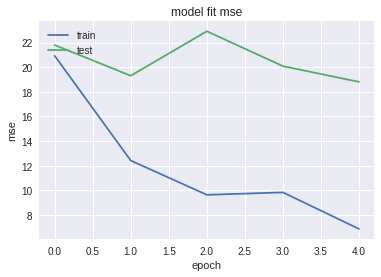

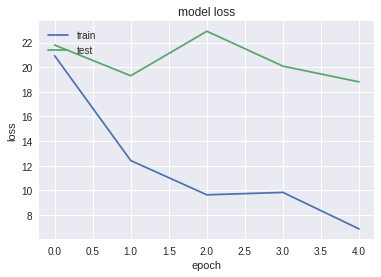

Test data...
4/4 [==============================] - 0s 39ms/step


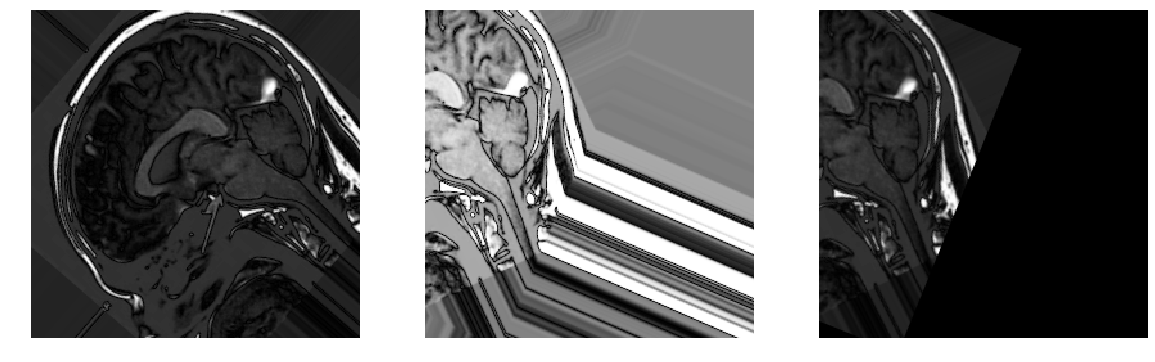

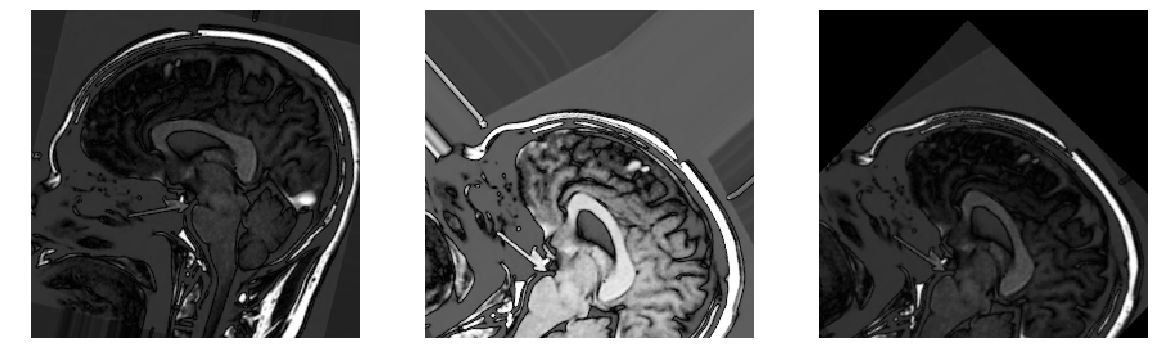

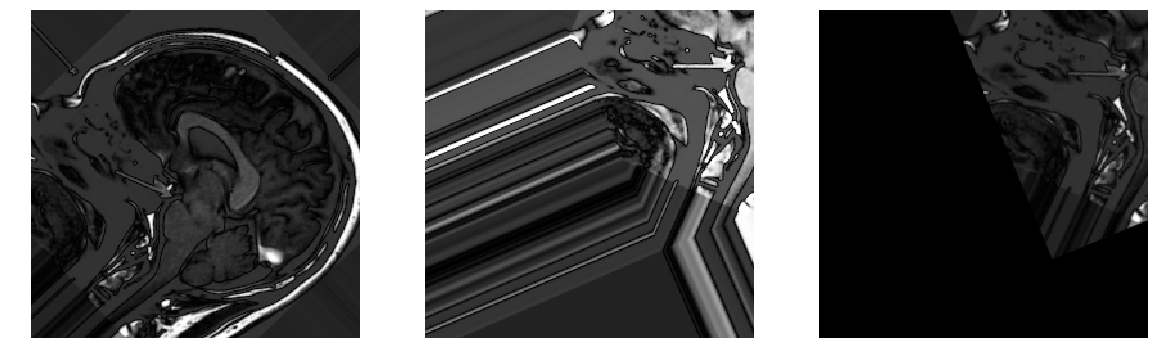

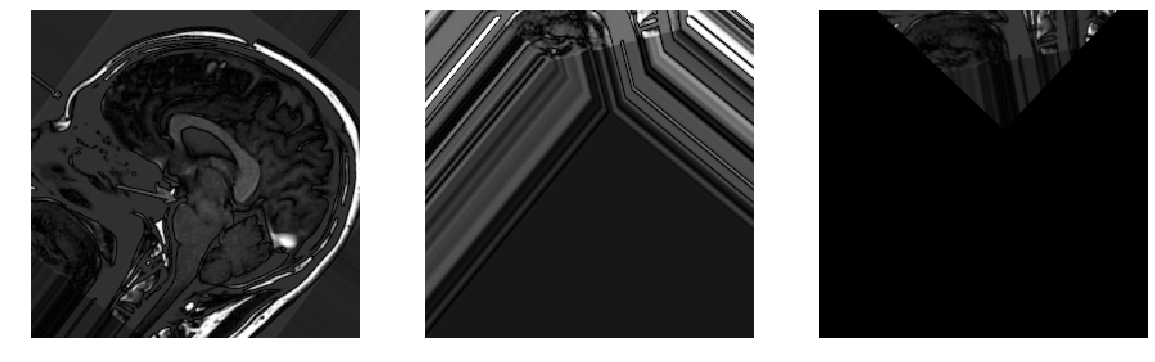

[[-22.118872  98.54284   30.822733]
 [-44.028233 -88.74337   73.93898 ]
 [ 22.335005 -94.225945   6.916622]
 [ 46.785454 -30.751894  86.73717 ]]
[[-23.67008173  96.6199551   37.64455892]
 [-48.72503074 -92.11070549  88.38114275]
 [ 23.38954721 -93.70132362   9.33868336]
 [ 50.53438456 -28.96487814  91.43434709]]


In [2]:
#AUM
#Shree Ganeshaya Namaha
import tensorflow as tf
tf.test.gpu_device_name()
from skimage import transform as tf
from skimage.transform import resize, rotate
from skimage.color import rgb2gray
from skimage.io import imread
from keras.layers import Input,Conv2D,concatenate,MaxPooling2D,Flatten,Dense,Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import numpy as np
from numpy.random import uniform
import matplotlib.pyplot as plt
from skimage.viewer import ImageViewer
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

%matplotlib inline

from google.colab import files
uploaded = files.upload()


K.set_image_data_format('channels_last')  # TF dimension ordering in this code

from keras import losses
img_rows = 256
img_cols = 256


#taken from: https://www.kaggle.com/bguberfain/elastic-transform-for-data-augmentation
# Function to distort image
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
#    M = cv2.getAffineTransform(pts1, pts2)
#    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)



def get_rr_net():
    inputs = Input((img_rows, img_cols, 2))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4_1 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4_1)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    flat1 = Flatten()(conv5)
    d1= Dense(512,activation='relu')(flat1)
    d2= Dense(64,activation='relu')(d1)

    out_theta = Dense(3)(d2)
#    conv_tx = Conv2D(1, (1, 1), activation=final_activation)(conv5)
#    conv_ty = Conv2D(1, (1, 1), activation=final_activation)(conv5)
#    conv_theta = Conv2D(1, (1, 1), activation='tanh')(conv5)

#    out_img = rotate(inputs,conv_theta)

    model = Model(inputs=[inputs], outputs=out_theta)

    model.compile(optimizer='adam', loss=losses.mean_squared_error, metrics=['mse'])

    return model


def gen_train_data(img, N=1024,  nodist=0):
    imgs_train = np.zeros((N, img.shape[0], img.shape[1], 2))
    noise = 0*uniform(low=-1,high=1,size=imgs_train.shape)
    out_train = np.zeros((N, 3))
    rot = uniform(low=-60, high=60, size=(N,1))
    tx = uniform(low=-100, high=100, size=(N,1))
    ty = uniform(low=-100, high=100, size=(N,1))
    out_train[:,0]=rot.squeeze()
    out_train[:,1]=tx.squeeze()
    out_train[:,2]=ty.squeeze()

    in_rot = uniform(low=-60, high=60, size=(N,1))
 
    for j in range(N):
      
#        img2 = tf.warp(img,aff)
        img2 = rotate(img, in_rot[j],mode='edge')
        img2 -= np.mean(img2)
        img2 /= np.std(img2)
        if nodist==0:
            img2 = elastic_transform(img2, img2.shape[1] * 1.2, img2.shape[1] * 0.08,img2.shape[1] * 0.08)
        
        imgs_train[j, :, :, 0] = img2 + (1.0-nodist)*noise[j,:,:,0]
       
        aff = tf.AffineTransform(rotation = (np.pi/180.0)*np.float(rot[j]), translation=(tx[j],ty[j]))

        #img3 = 10-1*np.tanh(img2) + 0*  noise[j,:,:,1]#
        img3 = 10-1*np.tanh(tf.warp(img2, aff, mode='edge')) +  (1.0-nodist)*noise[j,:,:,1]#
        
        if nodist == 0:
            img3 = elastic_transform(img3, img3.shape[1] * .2, img3.shape[1] * 0.08,img3.shape[1] * 0.08)

        img3 -= np.mean(img3)
        img3 /= np.std(img3)
        imgs_train[j, :, :, 1] = img3
        
        if 0:
            plt.imshow(img3)
            plt.show()
            
            plt.imshow(img2)
            plt.show()
             
    return imgs_train, out_train


def train_model():
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    img = resize(rgb2gray(imread('sample_brain.png')).astype('float32'),(img_rows,img_cols),mode='constant')
    mean = np.mean(img)  # mean for data centering
    std = np.std(img)  # std for data normalization

    img -= mean
    img /= std
    

    print('Creating and compiling model...')
    rrmodel = get_rr_net()
    rrmodel.load_weights('weights.h5')
    model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

    print('Fitting Model')
    for repind in range(100):
        imgs_train, out_train = gen_train_data(img, 512)
        history = rrmodel.fit(imgs_train, out_train, batch_size=64, epochs=5, verbose=1,
                              shuffle=True, validation_split=0.2,
                              callbacks=[model_checkpoint])

    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('model fit mse')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    
def test_model():
    
    print('Test data...')
    img = resize(rgb2gray(imread('sample_brain.png')).astype('float32'),(img_rows,img_cols),mode='reflect')
    mean = np.mean(img)  # mean for data centering
    std = np.std(img)  # std for data normalization

    img -= mean
    img /= std

    rrmodel = get_rr_net()
    rrmodel.load_weights('weights.h5')

    imgs_test, out_test = gen_train_data(img, 4, nodist=1)
#    plt.imshow(np.absolute(imgs_test[0,:,:,0].squeeze()),cmap='gray')
#    plt.imshow(np.absolute(imgs_test[0,:,:,1].squeeze()),cmap='gray')

    pred_theta = rrmodel.predict(imgs_test, verbose=1)

    for jj in range(4):
        fig=plt.figure(figsize=(20,10)); 
        fig.add_subplot(1,3,1);ax = plt.gca(); ax.grid(False)
        plt.axis('off')
        plt.imshow(np.absolute(imgs_test[jj,:,:,0].squeeze()),cmap='gray')
        fig.add_subplot(1,3,2);ax = plt.gca(); ax.grid(False)
        plt.axis('off')
        plt.imshow(np.absolute(imgs_test[jj,:,:,1].squeeze()),cmap='gray')
        aff = tf.AffineTransform(rotation = (np.pi/180.0)*pred_theta[jj,0], translation=(pred_theta[jj,1],pred_theta[jj,2]))
        img2 = tf.warp(np.absolute(imgs_test[jj,:,:,0].squeeze()),aff)
        fig.add_subplot(1,3,3);ax = plt.gca(); ax.grid(False)
        plt.axis('off')
        plt.imshow(img2,cmap='gray')
        plt.show()
    
    
    print(pred_theta)
    print(out_test)



if __name__ == '__main__':
    train_model()
    test_model()


In [5]:
from google.colab import files
files.download('weights.h5')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 48978, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 696, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil